In [1]:
import argparse
import os
import random
import numpy as np
import torch
import torch.backends.cudnn as cudnn
from tqdm import tqdm
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from torchvision.utils import save_image
from minigpt4.common.dist_utils import get_rank
from minigpt4.models import load_preprocess
from minigpt4.common.config import Config
from minigpt4.common.dist_utils import get_rank
from minigpt4.common.registry import registry
# imports modules for registration
from minigpt4.datasets.builders import *
from minigpt4.models import *
from minigpt4.processors import *
from minigpt4.runners import *
from minigpt4.tasks import *
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_image_token, process_images, get_model_name_from_path
from PIL import Image
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import re
import seaborn as sns
import math
MODEL_EVAL_CONFIG_PATH = {
    "minigpt4": "eval_configs/minigpt4_eval.yaml",
    "instructblip": "eval_configs/instructblip_eval.yaml",
    "lrv_instruct": "eval_configs/lrv_instruct_eval.yaml",
    "shikra": "eval_configs/shikra_eval.yaml",
    "llava-1.5": "eval_configs/llava-1.5_eval.yaml",
}

POPE_PATH = {
    "random": "coco_pope/coco_pope_random.json",
    "popular": "coco_pope/coco_pope_popular.json",
    "adversarial": "coco_pope/coco_pope_adversarial.json",
}

INSTRUCTION_TEMPLATE = {
    "minigpt4": "###Human: <Img><ImageHere></Img> <question> ###Assistant:",
    "instructblip": "<ImageHere><question>",
    "lrv_instruct": "###Human: <Img><ImageHere></Img> <question> ###Assistant:",
    "shikra": "USER: <im_start><ImageHere><im_end> <question> ASSISTANT:",
    "llava-1.5": "USER: <ImageHere> <question> ASSISTANT:"
}


def setup_seeds(config):
    seed = config.run_cfg.seed + get_rank()

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    cudnn.benchmark = False
    cudnn.deterministic = True


parser = argparse.ArgumentParser(description="POPE-Adv evaluation on LVLMs.")
parser.add_argument("--model", type=str, help="model")
parser.add_argument("--gpu-id", type=int, help="specify the gpu to load the model.")
parser.add_argument(
    "--options",
    nargs="+",
    help="override some settings in the used config, the key-value pair "
    "in xxx=yyy format will be merged into config file (deprecate), "
    "change to --cfg-options instead.",
)
parser.add_argument("--data_path", type=str, default="/mnt/petrelfs/share_data/wangjiaqi/mllm-data-alg/COCO_2014/ori/val2014/val2014/", help="data path")
parser.add_argument("--batch_size", type=int, help="batch size")
parser.add_argument("--num_workers", type=int, default=2, help="num workers")
args = parser.parse_known_args()[0]

args.model = "llava-1.5"
# args.model = "instructblip"
# args.model = "minigpt4"
# args.model = "shikra"
args.gpu_id = "0"
args.batch_size = 1


os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu_id)
args.cfg_path = MODEL_EVAL_CONFIG_PATH[args.model]
cfg = Config(args)
setup_seeds(cfg)
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

# ========================================
#             Model Initialization
# ========================================
print('Initializing Model')

model_config = cfg.model_cfg
model_config.device_8bit = args.gpu_id
model_cls = registry.get_model_class(model_config.arch)
model = model_cls.from_config(model_config).to(device)
model.eval()
processor_cfg = cfg.get_config().preprocess
processor_cfg.vis_processor.eval.do_normalize = False
vis_processors, txt_processors = load_preprocess(processor_cfg)
print(vis_processors["eval"].transform)
print("Done!")

mean = (0.48145466, 0.4578275, 0.40821073)
std = (0.26862954, 0.26130258, 0.27577711)
norm = transforms.Normalize(mean, std)

ModuleNotFoundError: No module named 'minigpt4'

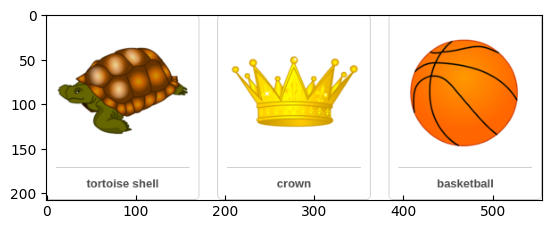

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.75s/it]
Some weights of the model checkpoint at /mnt/xiaofeng.zxf/models/clip-vit-large-patch14-336 were not used when initializing CLIPVisionModel: ['text_model.embeddings.position_embedding.weight', 'text_model.encoder.layers.4.layer_norm1.weight', 'text_model.encoder.layers.6.layer_norm1.bias', 'text_model.encoder.layers.10.self_attn.q_proj.weight', 'text_model.encoder.layers.11.self_attn.v_proj.bias', 'text_model.encoder.layers.5.self_attn.k_proj.bias', 'text_model.encoder.layers.0.mlp.fc2.bias', 'text_model.encoder.layers.6.layer_norm2.weight', 'text_model.encoder.layers.5.self_attn.v_proj.weight', 'text_model.encoder.layers.3.self_attn.out_proj.weight', 'text_model.encoder.layers.0.self_attn.v_proj.weight', 'text_model.encoder.layers.2.self_attn.k_proj.bias', 't

KeyError: 'Indexing with integers is not available when using Python based feature extractors'

In [32]:
model_path="/mnt/xiaofeng.zxf/models/llava-v1.5-7b"
model_name = get_model_name_from_path(model_path)
model_base=None
num_chunks=1
chunk_idx=0

def split_list(lst, n):
    """Split a list into n (roughly) equal-sized chunks"""
    chunk_size = math.ceil(len(lst) / n)  # integer division
    return [lst[i:i+chunk_size] for i in range(0, len(lst), chunk_size)]

def get_chunk(lst, n, k):
    chunks = split_list(lst, n)
    return chunks[k]
image_path = "/mnt/xiaofeng.zxf/code/LLaVA/ScienceQA_DATA/test/46/image.png"
raw_image = Image.open(image_path)
plt.imshow(raw_image)
plt.show()
raw_image = raw_image.convert("RGB")
image = vis_processors["eval"](raw_image).unsqueeze(0)
image = image.to(device)

tokenizer, model, image_processor = load_pretrained_model(model_path, model_base, model_name)
question = [{"content":"<image>\nContext: Figure: Daintree rain forest.\nThe Daintree rain forest is a tropical rain forest ecosystem in northeastern Australia.\nQuestion: Which better describes the Daintree rain forest ecosystem?\nOptions: (A) It has year-round rain. It also has soil that is poor in nutrients. (B) It has cold winters. It also has many different types of organisms.\nAnswer with the option's letter from the given choices directly."}]

prompt_str = '\n'.join([item['content'] for item in question])
template = INSTRUCTION_TEMPLATE[args.model]
# 现在 prompt_str 是一个字符串，可以用它来替换模板中的 <question> 占位符
qu = template.replace("<question>", prompt_str)
input_ids = tokenizer_image_token(qu,tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()
output_ids = model(
    input_ids=input_ids,
        use_cache=True,
        images=image,
        output_attentions=True,
)

input_token_len = input_ids.shape[1]
# n_diff_input_output = (input_ids != output_ids[:, :input_token_len]).sum().item()
# if n_diff_input_output > 0:
#     print(f'[Warning] {n_diff_input_output} output_ids are not the same as the input_ids')
output_text = tokenizer.batch_decode(output_ids[:, input_token_len:], skip_special_tokens=True)
output_text = [text.split('###')[0].strip() for text in output_text]
print(output_text)

# qu_append = out[0]
# qu = qu + qu_append

with torch.inference_mode():
    # with torch.no_grad():
    out = model(
        input_ids=input_ids,
        use_cache=True,
        images=image,
        output_attentions=True,
    )

print(len(out[-1]))  # 打印输出中最后一个 token 序列的长度
# 列表中第一个元素的形状。假设out是模型的输出，attentions字段可能包含了模型里每一层的注意力权重。
# 索引[0]表示我们查看第一层的注意力权重，
# print(out.attentions[0].shape)  #32  



In [7]:
import matplotlib.colors as mcolors
start_idx = 34  
end_idx = 610 # 到句子中某个特定标记 (如句号或冒号) 的索引
# 从34到609是图像token
for i in range(32):  # 循环处理1到32层
    attn_last = attns[i].max(1).values.data.squeeze()
    attn_last = attn_last / attn_last.sum(-1, keepdim=True)  # 标准化
    attention_scores_row_i_slice = attn_last[-1, start_idx:end_idx].cpu().numpy()
    grid_size = int(np.sqrt(attention_scores_row_i_slice.size))
    attn_grid = attention_scores_row_i_slice.reshape(grid_size, grid_size)
    
    # 绘图开始
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    plt.imshow(attn_grid, cmap='hot', alpha=0.5, extent=[0, raw_image.size[0], raw_image.size[1], 0])
    plt.clim(0.0005, attn_grid.max())
    plt.colorbar()
    plt.axis('off')
    
    # 保存图像
    file_name = f'./self_attention/答对/111_reason/layer{i+1}.png'  # 文件名从layer1开始
    plt.savefig(file_name)
    plt.close()  # 关闭当前绘制的图像，避免重叠



In [ ]:
print(torch.topk(out.attentions[31].mean(1).squeeze().mean(0), k=10)) #torch.Size([1, 32, 1262, 1262])
attns = [attn.clone() for attn in out.attentions]  # 复制列表中的每一个注意力张量
# [layer_id, bs, head_id, qk, v]
try:
    p_before, p_after = qu.split('<ImageHere>')
    p_before = model.system_message + p_before if args.model in ["shikra", "llava-1.5"] else p_before
    p_before_tokens = model.llama_tokenizer(
        p_before, return_tensors="pt", add_special_tokens=False).to("cuda").input_ids
    p_after_tokens = model.llama_tokenizer(
        p_after, return_tensors="pt", add_special_tokens=False).to("cuda").input_ids
    p_before_tokens = model.llama_tokenizer.convert_ids_to_tokens(p_before_tokens[0].tolist())
    p_after_tokens = model.llama_tokenizer.convert_ids_to_tokens(p_after_tokens[0].tolist())

    bos = torch.ones([1, 1], dtype=torch.int64, device="cuda") * model.llama_tokenizer.bos_token_id
    bos_tokens = model.llama_tokenizer.convert_ids_to_tokens(bos[0].tolist())
except:
    p_before, p_after = qu.split('<ImageHere>')
    p_before = model.system_message + p_before if args.model in ["shikra", "llava-1.5"] else p_before
    p_before_tokens = model.llm_tokenizer(
        p_before, return_tensors="pt", add_special_tokens=False).to("cuda").input_ids
    p_after_tokens = model.llm_tokenizer(
        p_after, return_tensors="pt", add_special_tokens=False).to("cuda").input_ids
    p_before_tokens = model.llm_tokenizer.convert_ids_to_tokens(p_before_tokens[0].tolist())
    p_after_tokens = model.llm_tokenizer.convert_ids_to_tokens(p_after_tokens[0].tolist())

    bos = torch.ones([1, 1], dtype=torch.int64, device="cuda") * model.llm_tokenizer.bos_token_id
    bos_tokens = model.llm_tokenizer.convert_ids_to_tokens(bos[0].tolist())

# print(qu)
# print(p_before_tokens)
# print(p_after_tokens)
# print(bos_tokens)

NUM_IMAGE_TOKENS = 256 if args.model == "shikra" else 32
NUM_IMAGE_TOKENS = 576 if args.model == "llava-1.5" else NUM_IMAGE_TOKENS
tokens = bos_tokens + p_before_tokens + ['img_token'] * NUM_IMAGE_TOKENS + p_after_tokens
seq_len = len(tokens)
len1 = len(bos_tokens + p_before_tokens)
if args.model == "instructblip":
    len2 = len(bos_tokens + p_before_tokens + ['img_token'] * NUM_IMAGE_TOKENS + p_after_tokens[:p_after_tokens.index(".")+1])
else:
    len2 = len(bos_tokens + p_before_tokens + ['img_token'] * NUM_IMAGE_TOKENS + p_after_tokens[:p_after_tokens.index(":")+1])
# print(len(tokens))
print(len1, len2)
tokens = [str(idx) + "-" + token for idx, token in enumerate(tokens)]
print(tokens)

# 最后，代码计算了注意力相关的指标并打印它们
# 这些包括所有头和层上的最大注意力值    
attn_last = attns[10].max(1).values.data.squeeze()
# 将注意力值标准化，使其之和为 1
attn_last = attn_last / attn_last.sum(-1, keepdim=True)
# 获取所有层和头上的最大注意力
attn_max = torch.cat([attn.unsqueeze(0) for attn in attns], dim=0).max(2).values.data.max(0).values.data.squeeze()
# 同样对这些值进行标准化
attn_max = attn_max / attn_max.sum(-1, keepdim=True)

#正则化保存图片名字
match = re.search(r'test/(\d+)/', image_path)
if match:
    specific_number = match.group(1)
    print(specific_number)  # 输出 '78'
else:
    print("No match found")
path = "./self_attention/{}/".format(args.model)
if not os.path.exists(path):
    os.mkdir(path)

plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号       
plt.rcParams['xtick.direction'] = 'in'
# plt.rcParams['ytick.direction'] = 'in'
def draw(data, x, y, ax):
    sns.heatmap(data, xticklabels=x, square=True, yticklabels=y, vmin=0, vmax=1.0, cbar=False, ax=ax)


# 指定想要可视化的 token 索引范围
start_idx = 34  
end_idx = 1200 # 到句子中某个特定标记 (如句号或冒号) 的索引

# 裁剪 attention 矩阵以及对应的标签
attn_slice = 5 * attn_last[start_idx:end_idx, start_idx:end_idx].cpu().numpy()
tokens_slice = tokens[start_idx:end_idx]

fig, axs = plt.subplots(1, 1, figsize=(100, 100))
draw(attn_slice, x=tokens_slice, y=tokens_slice, ax=axs)
# 显示图像
plt.show()
start_idx = 34  
end_idx = 610
# 裁剪 attention 矩阵以获取对应范围内的对角线值
diagonal_values = np.diag(attn_last[start_idx:end_idx, start_idx:end_idx].cpu().numpy())  # 你提取的真实注意力分数
print(diagonal_values.shape)

# 将得分重塑为24x24网格
attn_grid = diagonal_values.reshape(24, 24)

# 创建热力图，这将用作透明度图层
plt.figure(figsize=(10, 10))
plt.axis('off')  # 不显示坐标轴
plt.imshow(attn_grid, cmap='hot', interpolation='nearest')
plt.colorbar()  # 可选，显示颜色条

# 创建新的图，用于叠加原图和热力图
plt.figure(figsize=(10, 10))
plt.imshow(raw_image)  # 显示原图
plt.imshow(attn_grid, cmap='hot', alpha=0.5, extent=[0, raw_image.size[0], raw_image.size[1], 0])  # 热力图叠加
plt.axis('off')  # 不显示坐标轴
plt.show()

In [4]:

# 步骤1：获取注意力分数并激活梯度跟踪
attentions = out.attentions  # 假设out是模型的输出，并且包含注意力权重
for attn_layer in attentions:
    attn_layer.requires_grad_(True)

# 步骤2：选择预测输出并执行反向传播
# out.prediction_logits 或类似的输出，取决于模型的具体输出情况
prediction = out.prediction_logits
label_index = prediction.argmax(dim=-1)  # 获取输出索引，这里假设是argmax作为预测类别
prediction_score = prediction[:, label_index]  # 获取对应的得分
prediction_score.backward()  # 对得分进行反向传播，生成梯度

# 步骤3：获取梯度并与注意力分数相乘
# 注意力权重和梯度的shape可能是[num_layers, batch_size, num_heads, seq_length, seq_length]
# 而我们只对最后一个token的注意力分数乘梯度感兴趣。
gradient = [attn_layer.grad for attn_layer in attentions]  # 获取所有层的梯度
modified_attention = []
for attn_layer, grad_layer in zip(attentions, gradient):
    # 广播后点乘的shape可能是 [batch_size, num_heads, seq_length, seq_length]
    grad_weighted_attn = grad_layer * attn_layer
    # 可能需要进一步的处理，如取平均值等
    grad_weighted_attn = grad_weighted_attn.mean(dim=1)  # 假设我们合并头部的注意力
    modified_attention.append(grad_weighted_attn)
    
# 这里的modified_attention是一个包含所有处理后层的列表，每层包含经过梯度加权的注意力分数

# 步骤4：可视化
# 由于头部已合并，现在shape可能是[batch_size, seq_length, seq_length]
# 选择最后一层进行可视化
final_layer_attentions = modified_attention[-1][0]  # 获取第一个batch中的最后一层
# 此时需要处理visual token和句子token之间的注意力
# 比如将它们转换为一个合适的shape，如将visual token注意力reshape成2D形状的图片
# 可以使用 matplotlib 等来可视化这些注意力图



RuntimeError: Setting requires_grad=True on inference tensor outside InferenceMode is not allowed.